# Titanic: Machine Learning from Disaster

This is a kaggle ML competition, and my first kaggle competition.<br>
The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.


## Solution Process
This is a classification problem.

The dataset contains some missing values, I am going to clean the data by replacing the missing values as appropriate, I'm also going to perform som feature engineering by creating new features from existing ones.

I am going to use different classification algorithms to classify the data and choose the model with the best performance, I also decided to use an ensemble method to build a unique model and see how well that will also do. 

### Evaluation Metric
Accuracy Score

In [1]:
import warnings
warnings.filterwarnings('ignore')

Import the neccessary libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Data Dictionary

- Survived: 0 = No, 1 = Yes
- pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- ticket: Ticket number
- cabin: Cabin number
- embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton
- Total rows and columns

There are 891 rows and 12 columns in the training dataset.

In [5]:
df = pd.read_csv('train.csv')

In [6]:
#get the number of missing values from the dataset
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df.shape

(891, 12)

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Visualization and Exploration

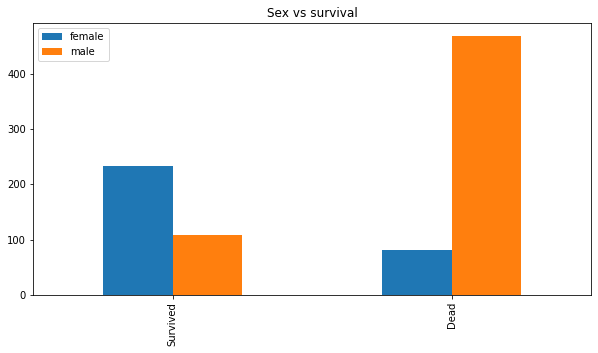

In [10]:
survived = df[df['Survived']==1]['Sex'].value_counts()
dead = df[df['Survived']==0]['Sex'].value_counts()

plot_df = pd.DataFrame([survived,dead])
plot_df.index = ['Survived','Dead']
plot_df.plot(kind='bar',stacked=False, figsize=(10,5))
plt.title('Sex vs survival')
plt.show()

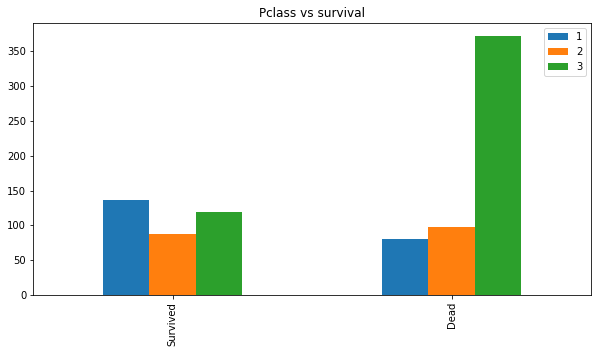

In [11]:
survived = df[df['Survived']==1]['Pclass'].value_counts()
dead = df[df['Survived']==0]['Pclass'].value_counts()

plot_df = pd.DataFrame([survived,dead])
plot_df.index = ['Survived','Dead']
plot_df.plot(kind='bar',stacked=False, figsize=(10,5))
plt.title('Pclass vs survival')
plt.show()

## Feature engineering

1. I created a new column **Family** containing the total number of family members each passenger has by adding the <b>Parch</b> and <b>Sibsp</b> columns together
2. I Extracted the title of each passenger from their name and created a new column called **Title**

4. I extracted the cabin group from the cabin column by removing the first letter in each cabin name and saved into a new column called **cabin_group**


## Data Cleaning

1. filled missing cabin with median cabin for each Pclass
2. Filled the missing age values with the mean for each Title class
3. Filled the missing embark values with the most popular embark value 'S'


## Data Preprocessing

1. I created classes for the title column, 
 - single/married ordinary man : 0
 - single woman : 1
 - married woman : 2
 - a man with a special title either royalty or work title:3
 - woman with a special title either royalty or work title: 4
 
2. I grouped the ages into bins
3. Grouped the fares into bins
4. Used Label Encoder to convert the embark column to numerical values
5. Used Label Encoder to convert the sex column to numerical values
6. Used Label Encoder to convert the ticket column to numerical values
7. Dropped some columns like **PassengerId, SibSp, Parch, Cabin, Name** to avoid data leakage and overloading the algorithm with excess data.


I created one function that performs all these so as to make my project modular and clean.

In [12]:
def transform_data(df):
    """
    The function takes in the titanic dataset and performs cleans, preprocesses the data
    and also does some feature engineering.
    
    OUTPUT: completely preprocessed dataframe
    """
    df['Family'] = df['SibSp'] + df['Parch']
    
    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 4,
                 "Ms": 2, "Lady": 4, "Jonkheer": 3, "Don": 3, "Dona" : 4, "Mme": 3,"Capt": 3,"Sir": 3 }
    df['Title'] = df['Title'].map(title_mapping)
    
    
    df["Age"].fillna(df.groupby("Title")["Age"].transform("mean"), inplace=True)
    df.loc[df['Age'] <= 13, 'Age'] = 0,
    df.loc[(df['Age'] > 13) & (df['Age'] <= 19), 'Age'] = 1,
    df.loc[(df['Age'] > 19) & (df['Age'] <= 30), 'Age'] = 2,
    df.loc[(df['Age'] > 30) & (df['Age'] <= 55), 'Age'] = 3,
    df.loc[df['Age'] > 55, 'Age'] = 4
    
    
    df['Cabin_name'] = df['Cabin'].str[:1]
    cabin_mapping = {"A": 0, "B": 1, "C": 2, "D": 2, "E": 4, "F": 5, "G": 6, "T": 7}
    df['Cabin_name'] = df['Cabin_name'].map(cabin_mapping)
    df["Cabin_name"].fillna(df.groupby("Pclass")["Cabin_name"].transform("median"), inplace=True)
    
    
    df.loc[df['Fare'] <= 5, 'Fare'] = 0,
    df.loc[(df['Fare'] > 5) & (df['Fare'] <= 15), 'Fare'] = 1,
    df.loc[(df['Fare'] > 15) & (df['Fare'] <= 30), 'Fare'] = 2,
    df.loc[(df['Fare'] > 30) & (df['Fare'] <= 50), 'Fare'] = 3,
    df.loc[df['Fare'] > 50, 'Fare'] = 6
    
    
    df['Embarked'] = df['Embarked'].fillna('S')
    le.fit(df['Embarked'])
    df['Embarked'] = le.transform(df['Embarked'])
    
    
    le.fit(df['Sex'])
    df['Sex'] = le.transform(df['Sex'])
    
    le.fit(df['Ticket'])
    df['Ticket'] = le.transform(df['Ticket'])
    
    df.drop(['PassengerId', 'SibSp', 'Parch', 'Cabin', 'Name'], axis=1, inplace=True)
    
    return df

In [13]:
#kaggle already did the work of splitting the data into the train and test set. This is the train set
data = df

In [14]:
train = transform_data(data)

train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Ticket        0
Fare          0
Embarked      0
Family        0
Title         0
Cabin_name    0
dtype: int64

In [15]:
train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Family,Title,Cabin_name
0,0,3,1,2.0,523,1.0,2,1,0,5.0
1,1,1,0,3.0,596,6.0,0,1,2,2.0
2,1,3,0,2.0,669,1.0,2,0,1,5.0
3,1,1,0,3.0,49,6.0,2,1,2,2.0
4,0,3,1,3.0,472,1.0,2,0,0,5.0


I used the **voting** ensembling methods, hard and soft voting

In [16]:
#initialize models

lr = LogisticRegression()
rand = RandomForestClassifier(random_state=1, n_estimators=100, criterion='gini', max_depth=1, min_samples_split=2, min_samples_leaf=1)
tree = DecisionTreeClassifier(random_state=1, min_samples_leaf=2, max_depth=12)


voting_hard = VotingClassifier(estimators=[('Logreg', lr),
                                          ('Random', rand),
                                          ('Decision', tree)],
                              voting='hard')

voting_soft = VotingClassifier(estimators=[('Logreg', lr),
                                          ('Random', rand),
                                          ('Decision', tree)],
                              voting='soft', weights =[0.50, 0.60, 0.40])

In [17]:
#separate the train set into features and target
x_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']

### Cross validation

I used cross validation to evaluate how well my model performed on the training data

In [18]:
for m in (lr, rand, tree, voting_hard, voting_soft):
    
    print(m.__class__.__name__, cross_val_score(m, x_train, y_train, cv=3).mean())

LogisticRegression 0.8069584736251403
RandomForestClassifier 0.7867564534231201
DecisionTreeClassifier 0.7934904601571269
VotingClassifier 0.8226711560044894
VotingClassifier 0.8226711560044894


### Observation
The voting classifier models have the highest cross validation scores on the training data followed by logistic regression model

### Testing

In [20]:
test = pd.read_csv('test.csv')

In [21]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
test.shape

(418, 11)

In [23]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [24]:
test = transform_data(test)

In [25]:
test.isnull().sum()

Pclass        0
Sex           0
Age           0
Ticket        0
Fare          1
Embarked      0
Family        0
Title         0
Cabin_name    0
dtype: int64

In [26]:
test["Fare"].mean()

2.3141486810551557

In [27]:
test['Fare'] = test['Fare'].fillna(2.3141486810551557)

In [28]:
test.isnull().sum()

Pclass        0
Sex           0
Age           0
Ticket        0
Fare          0
Embarked      0
Family        0
Title         0
Cabin_name    0
dtype: int64

In [29]:
y_test = pd.read_csv('gender_submission.csv')
y_test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [30]:
y_test.shape

(418, 2)

In [31]:
for m in (lr, rand, tree, voting_hard, voting_soft):
    m.fit(x, y)
    y_pred = m.predict(test)
    
    print(m.__class__.__name__, accuracy_score(y_test['Survived'], y_pred))

LogisticRegression 0.8923444976076556
RandomForestClassifier 0.9904306220095693
DecisionTreeClassifier 0.7344497607655502
VotingClassifier 0.9545454545454546
VotingClassifier 0.9138755980861244


In [32]:
for m in (lr, rand, tree, voting_hard, voting_soft):
    m.fit(x, y)
    y_pred = m.predict(test)
    
    print(m.__class__.__name__, confusion_matrix(y_test['Survived'], y_pred))

LogisticRegression [[233  33]
 [ 12 140]]
RandomForestClassifier [[262   4]
 [  0 152]]
DecisionTreeClassifier [[217  49]
 [ 62  90]]
VotingClassifier [[253  13]
 [  6 146]]
VotingClassifier [[245  21]
 [ 15 137]]


Overall The **random Forest classifier** had the highest accuracy score of an amazing **99%**. This is an incredibly high accuracy_score.

Although the ensemble models did really well on the training data they didn't perform as well on the test set.